In [1]:
import os
import sys
import gzip
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline

In [2]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf');

font = matplotlib.font_manager.FontProperties(fname='/System/Library/Fonts/Supplemental/Avenir.ttf')

In [3]:
plt.rcParams.update({'text.usetex': True,
                        'font.family': "sans-serif",
                        'text.latex.preamble': r"\usepackage{amsmath}"})

In [4]:
N = 1e6
regime = 'r'
rs = np.load('../simulations/out/%s_rs.npy' % regime) # loading R values

In [ ]:
# need to first process raw trajectories – this takes some time! 
# consider skipping this step and loading processed trajectories instead if they exist

'''
param_idx = 20

filename = os.path.join('../simulations/out', 'output_%s_%d.txt.gz' % (regime,param_idx))
file = gzip.GzipFile(filename,"r")
f11s = []
f10s = []
f01s = []

for line in file:

    if line.startswith(b'//'):
        continue
    items = line.split()

    f11 = float(items[0])
    f10 = float(items[1])
    f01 = float(items[2])

    f11s.append(f11)
    f10s.append(f10)
    f01s.append(f01)

file.close()

f11s = np.array(f11s)
f10s = np.array(f10s)
f01s = np.array(f01s)
f00s = 1 - f11s - f10s - f01s
fAs = f11s + f10s
fBs = f11s + f01s

all_fs = np.stack((f11s, f10s, f01s), axis=-1)
np.save(os.path.join('../simulations/out', 'fs_%s_%d'%(regime,param_idx)), all_fs)
'''


In [5]:
# alternatively, can load already processed trajectories
# feel free to skip this step too

# large NRf_0 first:
param_idx = 20 # alo use 12, 4
r = rs[param_idx]

all_fs = np.load(os.path.join('../simulations/out', 'fs_%s_%d.npy'%(regime,param_idx)))
f11s = all_fs[:, 0]
f10s = all_fs[:, 1]
f01s = all_fs[:, 2]
f00s = 1-f11s-f10s-f01s
fAs = f11s+f10s
fBs = f11s+f01s

# freq ranges
f_lims = [(0.0012, 0.0018), (0.004, 0.0056), (0.04, 0.056)]

for i, (f_min, f_max) in enumerate(f_lims):
    rho = 2 * N * r * np.sqrt(f_min * f_max)
    nrf2 = N * r * f_min * f_max
    mask = (fAs >= f_min) & (fAs <= f_max) & (fBs >= f_min) & (fBs <= f_max)
    lambdas = (f11s[mask]*f10s[mask]*f01s[mask]*f00s[mask]) / np.square(fAs[mask] * fBs[mask]*(1-fAs[mask])*(1-fBs[mask]))
    print(rho, nrf2, lambdas.mean())
    #np.save('../simulations/out/lambda2_distr_rho=' + '{:.3f}'.format(rho) + '_nrf0^2=' + '{:.3f}'.format(nrf2), lambdas)


165.29391695962315 0.12146572624111539 0.996904109588097
532.2969832256114 1.259644568426382 0.9963852866447509
5322.969832256114 125.96445684263821 0.9993487118882479


In [6]:
# downloading lambda distributions
lambda2_large_rho_large_nrff = np.load('../simulations/out/lambda2_distr_rho=5322.970_nrf0^2=125.964.npy')
lambda2_large_rho_nrff_1 = np.load('../simulations/out/lambda2_distr_rho=532.297_nrf0^2=1.260.npy')
lambda2_large_rho_small_nrff = np.load('../simulations/out/lambda2_distr_rho=165.294_nrf0^2=0.121.npy')
lambda2_small_rho_small_nrff = np.load('../simulations/out/lambda2_distr_rho=0.165_nrf0^2=0.001.npy')

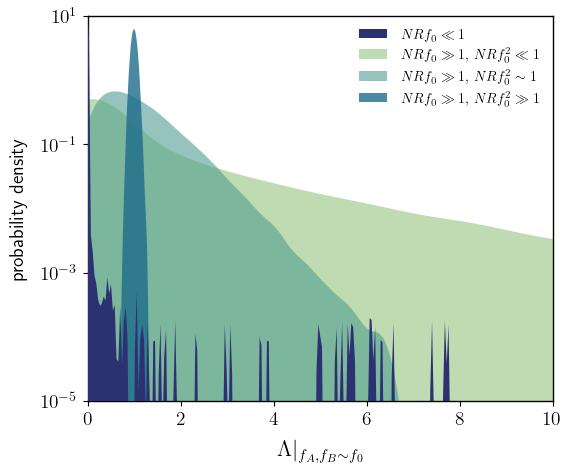

In [7]:
matplotlib.rcParams['axes.linewidth'] = 1

rhos = np.logspace(-4.5, 4.5, int(1e2))

fig = plt.figure(figsize=(6,5))

cmap = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=1, vmax=4),cmap=sns.color_palette("crest", as_cmap=True))
grey = '#b9b9b9' 
w = 1.25 # linewidth

sns.kdeplot(lambda2_small_rho_small_nrff, bw_adjust=2.5, fill=True, alpha=1, linewidth=0, 
            color=matplotlib.colors.rgb2hex(cmap.to_rgba(4)), zorder=4, label=r"$NRf_0 \ll 1$")

sns.kdeplot(lambda2_large_rho_small_nrff, bw_adjust=2.5, fill=True, alpha=0.7, linewidth=0, 
            color=matplotlib.colors.rgb2hex(cmap.to_rgba(1)), zorder=1, label=r"$NRf_0 \gg 1, \, NRf_0^2 \ll 1$")
sns.kdeplot(lambda2_large_rho_nrff_1, bw_adjust=2.5, fill=True, alpha=0.6, linewidth=0, 
            color=matplotlib.colors.rgb2hex(cmap.to_rgba(2)), zorder=2, label=r"$NRf_0 \gg 1, \, NRf_0^2 \sim 1$")
sns.kdeplot(lambda2_large_rho_large_nrff, bw_adjust=2.5, fill=True, alpha=0.8, linewidth=0, 
            color=matplotlib.colors.rgb2hex(cmap.to_rgba(3)), zorder=3, label=r"$NRf_0 \gg 1, \, NRf_0^2 \gg 1$")

plt.yscale('log')
plt.minorticks_off()
plt.tick_params(axis='both', labelsize=14)

plt.xticks([0, 2, 4, 6, 8, 10], 
           [r"$0$", r"$2$", r"$4$", r"$6$", r"$8$", r"$10$"])
plt.yticks([1e-5, 1e-3, 1e-1, 1e1], 
           ['$10^{-5}$', '$10^{-3}$', '$10^{-1}$', '$10^{1}$'])

plt.xlim(0, 10)
plt.ylim(1e-5, 1e1)

plt.ylabel(r"$\text{probability density}$", fontsize=14, labelpad=10);
plt.xlabel(r"$\Lambda\vert_{f_A, f_B \sim f_0}$", fontsize=16, labelpad=8);  

plt.legend(frameon=False, fontsize=10, loc='upper right', handletextpad=1);

#plt.savefig('fig6_v3.png',dpi=600,bbox_inches='tight') 